# Final Project for Yelp Dataset

### Mingrui Liu (ml4404), Zhiyi Guo (zg2350), Yujie Wang (yw3442), Congcheng Yan (cy2550), Banruo Xie (bx2168)
The project below builds four recommendation system models for lastest yelp user rating prediction. They are user-based model, time-aware model, collective factorization model and content-based model. Our objective is to compare these four models to the baseline model, user-based model, and decide which model is the best fit for this dataset. We choose accuracy metric as the primary performance evaluater in this project. For implementation, we use some open source packages to predict ratings and recommend restaurants.

For business purpose, this project is primarily designed for internal company use. After comparing different methods' performance with the baseline model, discussion will be further made for final decision of letting which model to be put into real world application. The model with more accuracy will be selected. Our business rule is to use recommendation to improve customer satisfaction, user engagement and increase the number of short-term and even long-term user. Therefore, the better recommendation model can help company increase user size and then boost revenue.

## Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import math
import json
from random import sample
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time
from tqdm import tqdm
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer
import warnings
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')

In [20]:
'''
import sample data
filter sample data, hold active users and active businesses for recommendation
we define active users as writing 5 or more ratings and active businesses as having 5 or more ratings
in order to have more original rating, we choose top 20% active businesses
later we select 50000 active users and 8500 active business for rating prediction
'''
line_count = len(open("review.json", "rb").readlines())
user_ids, business_ids, stars, dates = [], [], [], []
with open("review.json","rb") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
ratings = pd.DataFrame({"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates})

yelp = ratings.copy()

business_count = yelp["business_id"].value_counts()
active_business = business_count.loc[business_count >= 5]
k2 = active_business.quantile(0.8)
active_business = active_business.loc[active_business >= k2]
t2 = active_business.index.values
t2 = sample(t2.tolist(), 8500)
yelp = yelp[yelp['business_id'].isin(t2)]

user_count = yelp["user_id"].value_counts()
active_user = user_count.loc[user_count >= 5]
t1 = active_user.index.values
t1 = sample(t1.tolist(), 50000)
yelp = yelp[yelp['user_id'].isin(t1)]
print(len(yelp["user_id"].value_counts()))
print(len(yelp["business_id"].value_counts()))

100%|██████████| 6685900/6685900 [00:55<00:00, 120065.99it/s]


50000
8494


In [21]:
'''
see right now sample data
'''
yelp.head()

,user_id,business_id,rating,date
19,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06-27 21:19:23
34,DbccYu3OppWKl21OanZnTg,YSUcHqlKMPHHJ_cTrqtNrA,1.0,2017-12-29 13:55:19
36,_o740mSNRhMNYuPjSJoPLg,sMzNLdhJZGzYirIWt-fMAg,5.0,2015-06-21 00:59:14
48,8vIK6ndl8yzIdmSDnGp0tw,OVTZNSkSfbl3gVB9XQIJfw,4.0,2010-01-08 04:28:23
50,jsOz-dWToun2VsFcFAfGww,FBSWwaE6gR7KAOyG1QhakQ,5.0,2015-01-03 21:11:31


In [22]:
'''
split the dataset to train and test
as mentioned in instruction, we use data with lastest rating as test and the rest of data as train
'''
sample = yelp.copy()
sample['ind'] = sample.index
new_df = sample.sort_values(by=['user_id','date']).groupby("user_id")['date','ind'].max()
test = pd.DataFrame(new_df)
test = test.merge(sample, on=['user_id','date'], how='left')
train = sample[~sample['ind'].isin(np.array(test['ind_x']))]
train.head()

,user_id,business_id,rating,date,ind
19,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06-27 21:19:23,19
34,DbccYu3OppWKl21OanZnTg,YSUcHqlKMPHHJ_cTrqtNrA,1.0,2017-12-29 13:55:19,34
36,_o740mSNRhMNYuPjSJoPLg,sMzNLdhJZGzYirIWt-fMAg,5.0,2015-06-21 00:59:14,36
48,8vIK6ndl8yzIdmSDnGp0tw,OVTZNSkSfbl3gVB9XQIJfw,4.0,2010-01-08 04:28:23,48
50,jsOz-dWToun2VsFcFAfGww,FBSWwaE6gR7KAOyG1QhakQ,5.0,2015-01-03 21:11:31,50


In [23]:
'''
transform dataframe dataset to matrix for recommendation use
'''
train_table = pd.pivot_table(train, values='rating', index=['user_id'], columns=['business_id'])
train_table.head()

business_id,--7zmmkVg-IMGaXbuVd0SQ,--9e1ONYQuAa-CB_Rrw7Tw,--DaPTJW3-tB1vP-PfdTEg,--ujyvoQlwVoBgMYtADiLA,-050d_XIor1NpCuWkbIVaQ,-0DET7VdEQOJVJ_v6klEug,-0RkJ_uIduNLWQrphbADRw,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-2C96suwzrE_cqI1U69cLA,...,zw4Legbcu018p5WcZ74iWA,zw9_mqWBn1QCfZg88w0Exg,zwNC-Ow4eIMan2__bS9-rg,zwmps5SXn30g-f5wqg_r9A,zxSfGIhK3hH3vVz_pS5eaA,zyEQSfxX3FPIP6qyNsU0AA,zyPGYeXF4XKCqNN1pjFWhg,zydbdBR6-CM8UZ6WkW1DWA,zzUj3ej4vm_DtvRxNvWDEw,zzwhN7x37nyjP0ZM8oiHmw
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--2HUmLkcNHZp0xw6AMBPg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--2vR0DIsmQ6WfcSzKWigw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--4rAAfZnEIAKJE80aIiYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--BumyUHiO_7YsHurb9Hkw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1.Baseline Model: User-based Model

### Algorithm:
1. Determine a set of peers for every user<br>
2. Calculate the similarity of each user within the peer set, comparing users on items that they have both rated<br>
3. Use prediction function to fill in a user's missing rating (weighted average mean-centered rating from the users in the peer set)

(1) $\mu_u=\frac{\sum_{k \in I_u} r_{uk}}{|I_u|}$ <br>
(2) $s_{uj}=r_{uj}-\mu_u$<br>
(3) $r_{uj}=\mu_u+\frac{\sum_{v \in P_u(j)} Sim(u,v)(r_{vj}-\mu_v)}{\sum_{v \in P_u(j)}|Sim(u,v)|}$

In [17]:
'''
use pearson coefficient to find similarity between all users
input: original data matrix
output: similarity matrix of all users
'''
def update_pearson(df):
    val_arr = df.values.copy()
    corr = []
    for i in range(0, len(val_arr)):
        valid = sorted(np.argwhere(~np.isnan(val_arr[i])).flatten())
        corr.append(valid)

    values = df.values.copy()
    arr = np.zeros((df.shape[0],df.shape[0]))
    for i in range(0, len(values)):
        for j in range(i, len(values)):
            row1 = values[i]
            row2 = values[j]
            valid1 = corr[i]
            valid2 = corr[j]
            common = list(set(valid1) & set(valid2))
            if len(common) <= 2:
                arr[i,j]=0
                arr[j,i]=0
                continue
                
            row_1 = row1[common]
            row_2 = row2[common]
            pearson = pearsonr(row_1,row_2)[0]
            arr[i,j] = pearson
            arr[j,i] = pearson
            
    d = pd.DataFrame(arr)
    
    return d

In [25]:
'''
predict ratings for each user and business in original data matrix
input: original data matrix, top k similar users for each user (neighbor size)
output: data matrix with all predicted ratings
'''
def predict(df, k):
    mu = df.mean(axis=1).values
    d = update_pearson(df)
    d = d.where(d.apply(lambda x: x.isin(x.nlargest(k)),axis=0),0)
    p_sum = d.abs().sum(axis=1).values
    subtract = df.sub(df.mean(axis=1), axis=0)
    r = np.where(np.isnan(d.values),0,d.values).dot(np.where(np.isnan(subtract.values),0,subtract.values))
    cp = df.values.copy()
    
    for (i,j), values in np.ndenumerate(cp):
        values = r[i,j]/p_sum[i]+mu[i]
        cp[i][j] = values
        
    df_result = pd.DataFrame(cp)
    df_result.columns = list(df.columns)
    df_result.index = list(df.index)
    
    return df_result

In [26]:
'''
here we use neighbor size as 50 for the first try
'''
pre = predict(train_table, 50)

In [27]:
pre.head()

,--7zmmkVg-IMGaXbuVd0SQ,--9e1ONYQuAa-CB_Rrw7Tw,--DaPTJW3-tB1vP-PfdTEg,--ujyvoQlwVoBgMYtADiLA,-050d_XIor1NpCuWkbIVaQ,-0DET7VdEQOJVJ_v6klEug,-0RkJ_uIduNLWQrphbADRw,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-2C96suwzrE_cqI1U69cLA,...,zw4Legbcu018p5WcZ74iWA,zw9_mqWBn1QCfZg88w0Exg,zwNC-Ow4eIMan2__bS9-rg,zwmps5SXn30g-f5wqg_r9A,zxSfGIhK3hH3vVz_pS5eaA,zyEQSfxX3FPIP6qyNsU0AA,zyPGYeXF4XKCqNN1pjFWhg,zydbdBR6-CM8UZ6WkW1DWA,zzUj3ej4vm_DtvRxNvWDEw,zzwhN7x37nyjP0ZM8oiHmw
---1lKK3aKOuomHnwAkAow,3.875000,3.889251,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,...,3.875000,3.875000,4.006641,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000
--2HUmLkcNHZp0xw6AMBPg,4.583333,4.583333,4.583333,4.583333,4.649371,4.583333,4.583333,4.583333,4.583333,4.583333,...,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333
--2vR0DIsmQ6WfcSzKWigw,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,...,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667
--4rAAfZnEIAKJE80aIiYg,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,...,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000
--BumyUHiO_7YsHurb9Hkw,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,...,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857


## Recommend

In [28]:
'''
use predicted data matrix to recommend business to a specific user
input: predicted data matrix, how many businesses recommended to a user, userid
output: userid, businessid, predicted rating
'''
def recommend(df, k, userid):
    df_t = df.transpose()
    index = list(df_t.nlargest(k, userid).iloc[:,2].index)
    rating = list(df_t.nlargest(k, userid).iloc[:,2].values)
    rec = zip([userid]*k, index, rating)
    
    return list(rec)

In [29]:
recommend(pre, 5, '--2vR0DIsmQ6WfcSzKWigw')

[('--2vR0DIsmQ6WfcSzKWigw', 'El4FC8jcawUVgw_0EIcbaQ', 4.3506054788798085),
 ('--2vR0DIsmQ6WfcSzKWigw', '3xmfT7l3xNH5LK1dLzfvGw', 4.039746188002329),
 ('--2vR0DIsmQ6WfcSzKWigw', 'SLJX2dksO_BeNMQUe3Nr8Q', 3.8178559737580944),
 ('--2vR0DIsmQ6WfcSzKWigw', 'Az_60nNuh1FH8Ds8oasZjw', 3.8082445116423793),
 ('--2vR0DIsmQ6WfcSzKWigw', 'A5Rkh7UymKm0_Rxm9K2PJw', 3.804158724448768)]

## Evaluation

Here we use accuracy metric as our performance evaluater. We choose MSE as our primary accuracy metric and NDCG as our secondary accuracy metric. MSE stands for mean square error, which measures the average squared difference between estimated value and actual value. NDCG stands for normalized discounted cumulative gain, which measures ranking quality. In other words, we expect MSE to be as small as possible and NDCG as large as possible.

As mentioned in the instruction and introduction, our objective is to predict the lastest raing of each yelp ueser. Thus, our test set should always be the lastest rating. Under this circumstance, we cannot use cross validation to tune the model. Thus, we use the same train and test to tune some hyperparameters.

In [30]:
'''
we use online reference code to compute ndcg score for the model
https://gist.github.com/mblondel/7337391
'''
def dcg_score(y_true, y_score, k=10, gains="exponential"):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual/best

In [31]:
'''
we try different neighbor size to see which one has the best performance
input: a list of different k
output: MSE and NDCG for each k
'''
def tune_neighbor(list_k):
    mse = []
    ndcg = []
    
    for k in list_k:
        comp = predict(train_table, k)
        comp['id'] = list(train_table.index)
        comp = pd.melt(comp, id_vars=['id'])
        comp.rename(columns = {'id':'user_id', 'variable':'business_id'}, inplace = True)
        combine = pd.merge(comp, test, how='inner', on=['user_id', 'business_id'])
        combine = combine.dropna(subset=['value'])

        pred = combine.value
        true = combine.rating
        mse.append(mean_squared_error(pred, true))
        ndcg.append(ndcg_score(true.values, pred.values, k=10, gains="exponential"))
    
    evaluate = list(zip(mse, ndcg))
  
    return evaluate

In [39]:
list_k = [5, 10, 50, 100]
metric = tune_neighbor(list_k)

In [41]:
metric = pd.DataFrame(metric, columns=['mse','ndcg'])
metric['k'] = list_k
metric

,mse,ndcg,k
0,0.496998,0.928329,5
1,0.521494,1.000000,10
2,0.598711,1.000000,50
3,0.630271,1.000000,100


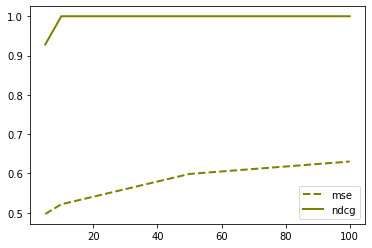

In [42]:
plt.plot('k', 'mse', data=metric, marker='', color='olive', linewidth=2, linestyle='dashed', label="mse")
plt.plot('k', 'ndcg', data=metric, marker='', color='olive', linewidth=2, label="ndcg")
plt.legend()
plt.show()

Based on the above graph, we can conclude that this model is great since the MSE is all smaller than 1 and NDCG is close to 1 and even equal to 1 for some neighbor sizes. Moreover, we can see that both MSE and NDCG increase as the neighbor size increases. Recall that we want to MSE to be as small as possible and NDCG as large as possible. Thus, we need to make a balance between them. Personally, in this case, I will suggest that neighbor size between 10 and 50 is better for this model.

# 2.Time-aware User-based Model

In order to have a more accurate rating, we now take each rating's date into account. Time-aware user-based model is similar to user-based model except with an extra time weight for each rating. The time weight is calculated by exponential decay of each rating's date. That is, if the rating has latest date, it will have a higher time weight because the latest raing has more reliability and vice versa.

(1) $w_{uj}(t_f)=exp[-\lambda(t_f-t_{uj})]$ <br>
(2) $r_{uj}=\mu_u+\frac{\sum_{v \in P_u(j)} w_{uj}(t_f)Sim(u,v)(r_{vj}-\mu_v)}{\sum_{v \in P_u(j)}w_{uj}(t_f)|Sim(u,v)|}$

In [32]:
'''
remove day in date column for calculating time decay
'''
train['date'] = train['date'].astype(str) 
train['date'] = train['date'].str.slice(0, 7, 1)

In [33]:
'''
calculate time decay corresponding with rating date using exponential decay
here we use lambda as 0.1 for the first try
'''
m = train['date'].values
m_sorted = sorted(m)
time = pd.DataFrame(np.unique(m_sorted), columns = ['date'])
time['exp'] = time.index
time['exp'] = time['exp'].astype(np.float16)
k = max(time['exp'])
exp_col = np.array(time["exp"])
func = lambda x: math.exp(-0.1*(k-x))
new_exp = list(map(func, exp_col))
time['time_weight'] = new_exp
train_new = train.merge(time, on='date', how='left')
train_new.head()

,user_id,business_id,rating,date,ind,exp,time_weight
0,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06,19,112.0,0.004992
1,DbccYu3OppWKl21OanZnTg,YSUcHqlKMPHHJ_cTrqtNrA,1.0,2017-12,34,154.0,0.332871
2,_o740mSNRhMNYuPjSJoPLg,sMzNLdhJZGzYirIWt-fMAg,5.0,2015-06,36,124.0,0.016573
3,8vIK6ndl8yzIdmSDnGp0tw,OVTZNSkSfbl3gVB9XQIJfw,4.0,2010-01,48,59.0,0.000025
4,jsOz-dWToun2VsFcFAfGww,FBSWwaE6gR7KAOyG1QhakQ,5.0,2015-01,50,119.0,0.010052


In [34]:
'''
create a data matrix for each rating's time weight
'''
train_table_new = pd.pivot_table(train_new, values='rating', index=['user_id'], columns=['business_id'])
time_table = pd.pivot_table(train_new, values='time_weight', index=['user_id'], columns=['business_id'])
time_table.head()

business_id,--7zmmkVg-IMGaXbuVd0SQ,--9e1ONYQuAa-CB_Rrw7Tw,--DaPTJW3-tB1vP-PfdTEg,--ujyvoQlwVoBgMYtADiLA,-050d_XIor1NpCuWkbIVaQ,-0DET7VdEQOJVJ_v6klEug,-0RkJ_uIduNLWQrphbADRw,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-2C96suwzrE_cqI1U69cLA,...,zw4Legbcu018p5WcZ74iWA,zw9_mqWBn1QCfZg88w0Exg,zwNC-Ow4eIMan2__bS9-rg,zwmps5SXn30g-f5wqg_r9A,zxSfGIhK3hH3vVz_pS5eaA,zyEQSfxX3FPIP6qyNsU0AA,zyPGYeXF4XKCqNN1pjFWhg,zydbdBR6-CM8UZ6WkW1DWA,zzUj3ej4vm_DtvRxNvWDEw,zzwhN7x37nyjP0ZM8oiHmw
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NaN,0.000006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--2HUmLkcNHZp0xw6AMBPg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--2vR0DIsmQ6WfcSzKWigw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--4rAAfZnEIAKJE80aIiYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--BumyUHiO_7YsHurb9Hkw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
'''
since time-aware user-based model has the same similar matrix with user-based model
we continue using update_pearson function, and modify predict function a little to predict rating with time weight
'''
def predict_time(df, time_table, k):
    
    mu = df.mean(axis=1).values
    d = update_pearson(df)
    d = d.where(d.apply(lambda x: x.isin(x.nlargest(k)), axis=0), 0)
    ti = time_table.fillna(0)
    time_val = ti.values
    d_val = d.values
    
    subtract = df.sub(df.mean(axis=1), axis=0)
    temp = np.multiply(time_val, subtract)
    r = np.where(np.isnan(d.values), 0, d.values).dot(np.where(np.isnan(temp.values), 0, temp.values))
    dem = np.where(np.isnan(d.values), 0, abs(d.values)).dot(np.where(np.isnan(time_table.values), 0, time_table.values))
    p_sum = dem.sum(axis=0)
    cp = df.values.copy()
    
    for (i,j), values in np.ndenumerate(cp):
        values = mu[i] + r[i,j]/p_sum[j]
        cp[i][j] = values
        
    df_result = pd.DataFrame(cp)
    df_result.columns = list(df.columns)
    df_result.index = list(df.index)
    
    return df_result

In [36]:
'''
here we use neighbor size as 50 and lambda as 0.1 for the first try
'''
pre_time = predict_time(train_table_new, time_table, 50)

In [37]:
pre_time.head()

,--7zmmkVg-IMGaXbuVd0SQ,--9e1ONYQuAa-CB_Rrw7Tw,--DaPTJW3-tB1vP-PfdTEg,--ujyvoQlwVoBgMYtADiLA,-050d_XIor1NpCuWkbIVaQ,-0DET7VdEQOJVJ_v6klEug,-0RkJ_uIduNLWQrphbADRw,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-2C96suwzrE_cqI1U69cLA,...,zw4Legbcu018p5WcZ74iWA,zw9_mqWBn1QCfZg88w0Exg,zwNC-Ow4eIMan2__bS9-rg,zwmps5SXn30g-f5wqg_r9A,zxSfGIhK3hH3vVz_pS5eaA,zyEQSfxX3FPIP6qyNsU0AA,zyPGYeXF4XKCqNN1pjFWhg,zydbdBR6-CM8UZ6WkW1DWA,zzUj3ej4vm_DtvRxNvWDEw,zzwhN7x37nyjP0ZM8oiHmw
---1lKK3aKOuomHnwAkAow,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,...,3.875000,3.875000,3.875004,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000,3.875000
--2HUmLkcNHZp0xw6AMBPg,4.583333,4.583333,4.583333,4.583333,4.583357,4.583333,4.583333,4.583333,4.583333,4.583333,...,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333,4.583333
--2vR0DIsmQ6WfcSzKWigw,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,...,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667,3.666667
--4rAAfZnEIAKJE80aIiYg,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,...,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000
--BumyUHiO_7YsHurb9Hkw,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,...,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857,4.142857


## Recommend

In [38]:
'''
we use the same recommend function as before
'''
recommend(pre_time, 5, '--2vR0DIsmQ6WfcSzKWigw')

[('--2vR0DIsmQ6WfcSzKWigw', '3nzK3K-Dfo1L6mpB8FTKkw', 3.6736897944424443),
 ('--2vR0DIsmQ6WfcSzKWigw', '7d7pZlKji6NozhHP1SrVqw', 3.672532427779577),
 ('--2vR0DIsmQ6WfcSzKWigw', 'SLJX2dksO_BeNMQUe3Nr8Q', 3.6723831862174987),
 ('--2vR0DIsmQ6WfcSzKWigw', 'uoUa8ugZLrly0bA268IqEg', 3.6715072814633736),
 ('--2vR0DIsmQ6WfcSzKWigw', 'WbbZDPuOEZxFprio05Bb0w', 3.6705669602245528)]

## Evaluation

Here we use the same evaluation method as the baseline model, which is MSE and NDCG.

In [43]:
'''
we try different neighbor size to see which one has the best performance
input: a list of different k
output: MSE and NDCG for each k
'''
def tune_neighbor_time(list_k):
    mse = []
    ndcg = []
    
    for k in list_k:
        comp = predict_time(train_table_new, time_table, k)
        comp['id'] = list(train_table_new.index)
        comp = pd.melt(comp, id_vars=['id'])
        comp.rename(columns = {'id':'user_id', 'variable':'business_id'}, inplace = True)
        combine = pd.merge(comp, test, how='inner', on=['user_id', 'business_id'])
        combine = combine.dropna(subset=['value'])

        pred = combine.value
        true = combine.rating
        mse.append(mean_squared_error(pred, true))
        ndcg.append(ndcg_score(true.values, pred.values, k=10, gains="exponential"))
    
    evaluate = list(zip(mse, ndcg))
  
    return evaluate

In [44]:
list_k = [5, 10, 50, 100]
metric_1 = tune_neighbor_time(list_k)

In [45]:
metric_1 = pd.DataFrame(metric_1, columns=['mse','ndcg'])
metric_1['k'] = list_k
metric_1

,mse,ndcg,k
0,1.327774,1.000000,5
1,1.333515,0.950745,10
2,1.342829,1.000000,50
3,1.344806,1.000000,100


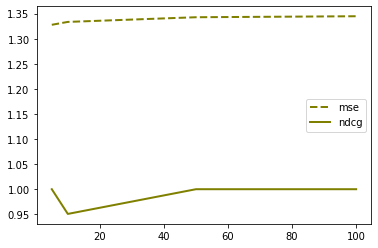

In [46]:
plt.plot('k', 'mse', data=metric_1, marker='', color='olive', linewidth=2, linestyle='dashed', label="mse")
plt.plot('k', 'ndcg', data=metric_1, marker='', color='olive', linewidth=2, label="ndcg")
plt.legend()
plt.show()

Based on the above graph, we can conclude that this model is good since the MSE is small and NDCG is close to 1 and even equal to 1 for some neighbor sizes, but it is not good as the baseline model. Moreover, we can see that MSE increases as the neighbor size increases, but NDCG is the best when neighbor size is 10. Recall that we want to MSE to be as small as possible and NDCG as large as possible. Thus, in this case, I will suggest that neighbor size 5 is better for this model.

In [72]:
'''
we try different lambda to see which one has the best performance
input: a list of different lambda
output: MSE and NDCG for each lambda
'''
def tune_lamda(list_lamda):
    mse = []
    ndcg = []
    
    for l in list_lamda:
        p = train['date'].values
        p_sorted = sorted(p)
        time_p = pd.DataFrame(np.unique(p_sorted), columns = ['date'])
        time_p['exp'] = time_p.index
        time_p['exp'] = time_p['exp'].astype(np.float16)
        k_p = max(time_p['exp'])
        exp_col_p = np.array(time_p["exp"])
        func_p = lambda x: math.exp(-l*(k_p-x))
        new_exp_p = list(map(func_p, exp_col_p))
        time_p['time_weight'] = new_exp_p
        train_new_p = train.merge(time_p, on='date', how='left')
        train_table_p = pd.pivot_table(train_new_p, values='rating', index=['user_id'], columns=['business_id'])
        time_table_p = pd.pivot_table(train_new_p, values='time_weight', index=['user_id'], columns=['business_id'])

        comp = predict_time(train_table_p, time_table_p, 5)
        comp['id'] = list(train_table_p.index)
        comp = pd.melt(comp, id_vars=['id'])
        comp.rename(columns = {'id':'user_id', 'variable':'business_id'}, inplace = True)
        combine = pd.merge(comp, test, how='inner', on=['user_id', 'business_id'])
        combine = combine.dropna(subset=['value'])

        pred = combine.value
        true = combine.rating
        mse.append(mean_squared_error(pred, true))
        ndcg.append(ndcg_score(true.values, pred.values, k=10, gains="exponential"))
    
    evaluate = list(zip(mse, ndcg))
    
    return evaluate

In [817]:
list_lamda = [0.001, 0.01, 0.1, 0.5]
metric_2 = tune_lamda(list_lamda)

In [3]:
metric_2 = pd.DataFrame(metric_2, columns=['mse','ndcg'])
metric_2['lamda'] = list_lamda
metric_2

,mse,ndcg,lamda
0,1.377390,1.0,0.001
1,1.347982,1.0,0.010
2,1.342829,1.0,0.100
3,1.337460,1.0,0.500


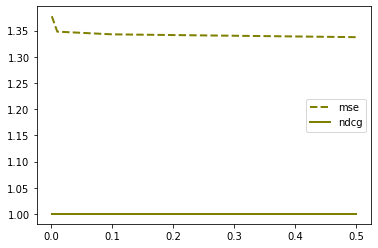

In [5]:
plt.plot('lamda', 'mse', data=metric_2, marker='', color='olive', linewidth=2, linestyle='dashed', label="mse")
plt.plot('lamda', 'ndcg', data=metric_2, marker='', color='olive', linewidth=2, label="ndcg")
plt.legend()
plt.show()

Based on the above graph, we can conclude that this model is good since the MSE is small and NDCG is 1 for all lambda values, but it is not good as the baseline model. Moreover, we can see that MSE decreases as the lambda increases, and NDCG remains the same for all lambda values. Recall that we want to MSE to be as small as possible and NDCG as large as possible. Thus, in this case, I will suggest that lambda 0.5 is better for this model.

Since the MSE of time-aware model is larger than baseline model, we conclude that the accuracy of time-aware model is worse than baseline model. As for the reason time-aware is worse, personally, I suggest that although some of ratings have old dates, they still have the same weight meaning of prediction because usually businesses (restaurants) will not largely changed in the short period of time. Thus, time weight is not important in this case.

## Less Popular Data

In [3]:
'''
in order to test the model with unpopular data
we choose top 50% active businesses rather than top 20%
'''
line_count = len(open("review.json", "rb").readlines())
user_ids, business_ids, stars, dates = [], [], [], []
with open("review.json","rb") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
ratings = pd.DataFrame({"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates})

yelp = ratings.copy()

business_count = yelp["business_id"].value_counts()
active_business = business_count.loc[business_count >= 5]
k2 = active_business.quantile(0.5)
active_business = active_business.loc[active_business >= k2]
t2 = active_business.index.values
t2 = sample(t2.tolist(), 20000)
yelp = yelp[yelp['business_id'].isin(t2)]

user_count = yelp["user_id"].value_counts()
active_user = user_count.loc[user_count >= 5]
t1 = active_user.index.values

t1 = sample(t1.tolist(), 50000)
yelp = yelp[yelp['user_id'].isin(t1)]
print(len(yelp["user_id"].value_counts()))
print(len(yelp["business_id"].value_counts()))

100%|██████████| 6685900/6685900 [00:56<00:00, 119354.44it/s]


50000
19831


In [3]:
sample = yelp.copy()
sample['ind'] = sample.index
new_df = sample.sort_values(by=['user_id','date']).groupby("user_id")['date','ind'].max()
test = pd.DataFrame(new_df)
test = test.merge(sample, on=['user_id','date'], how='left')
train = sample[~sample['ind'].isin(np.array(test['ind_x']))]

train['date'] = train['date'].astype(str) 
train['date'] = train['date'].str.slice(0, 7, 1)

m = train['date'].values
m_sorted = sorted(m)
time = pd.DataFrame(np.unique(m_sorted), columns = ['date'])
time['exp'] = time.index
time['exp'] = time['exp'].astype(np.float16)
k = max(time['exp'])
exp_col = np.array(time["exp"])
func = lambda x: math.exp(-0.1*(k-x))
new_exp = list(map(func, exp_col))
time['time_weight'] = new_exp
train_new = train.merge(time, on='date', how='left')
train_new.head()

,user_id,business_id,rating,date,ind,exp,time_weight
0,sBQnwE7tTiURm6RKamqWyA,ar27DwWW4V0eKTr_4rOFGQ,2.0,2016-03,225,122.0,0.040762
1,MWuVbyBgP4vD24Rc7UH5xw,nEQFnHydeX2A3bRRDAKqQg,3.0,2015-02,523,109.0,0.011109
2,C7lXOTSLUAHG3gkG_Q_39w,Vhszq28BSjUnMkFRib3MRw,4.0,2016-03,748,122.0,0.040762
3,JaqcCU3nxReTW2cBLHounA,Os1n1_idfw9vv9kwULGJnQ,4.0,2017-01,781,132.0,0.110803
4,b34yOQoUDev_l6BzDBMpUQ,EhtKeNUGGWnjsCLIhCD1jQ,5.0,2010-10,821,57.0,0.000061


In [4]:
train_table_new = pd.pivot_table(train_new, values='rating', index=['user_id'], columns=['business_id'])
time_table = pd.pivot_table(train_new, values='time_weight', index=['user_id'], columns=['business_id'])

In [7]:
pre_time_unpop = predict_time(train_table_new, time_table, 5)

In [11]:
pre_time_unpop['id'] = list(train_table_new.index)
pre_time_unpop = pd.melt(pre_time_unpop, id_vars=['id'])
pre_time_unpop.rename(columns = {'id':'user_id', 'variable':'business_id'}, inplace = True)
combine = pd.merge(pre_time_unpop, test, how='inner', on=['user_id', 'business_id'])
combine = combine.dropna(subset=['value'])

pred = combine.value
true = combine.rating
mse = mean_squared_error(pred, true)

In [4]:
mse

1.5307461252111367

Based on the above result, we can see that MSE is larger than original time-aware model. That is, with unpopular businesses and users, the model does not perform well as before. It is reasonable because with less popular data, we have more nan data in user-business matrix, which means we need to predict more ratings based on less original ratings. Thus, in order to have more accurate results, we should use more popular dataset.

# 3.Content-based Model
 
The second model we used is content-based recommendation model. Unlike other filters that need other users’ preferences, recommendations that we made for specific users only depend on information of themselves. 

There are three general parts to implement content-based recommendations:
1.	Preprocess, extract features and build vector-space representation of each item.
2.	Build user profiles.
3.	Filter and recommend by combining item content and user profiles.

For our project, we can build item profile by extracting business categories and attributes and build user profile by using  users’ preferences which are ratings they made in the past. After building our model, we can recommend for each user a list of recommendations for stores/shops according to their preferences and predict ratings for businesses made by users.

For  Yelp Datasets, we need to use metadata on the business(business.json) and review.json to build our model and make recommendations for each user.

## Data Preprocess:
To build profile for items, we extracted useful columns from large Dataframe:<br>
“business_id”—the identification number of each business;<br>
“category”—the classification keywords for the business;<br>
“attributes”—similar to “category”, keywords describing the business made by users. <br>

In [3]:
## read in the business profile file

line_count = len(open("business.json").readlines())
business_ids, categories, attr= [], [], []
with open("business.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        business_ids += [blob["business_id"]]
        categories += [blob["categories"]]
        attr += [blob["attributes"]]
business = pd.DataFrame(
{"business_id": business_ids, "category": categories,"attr": attr}
)

100%|██████████| 192609/192609 [00:02<00:00, 67043.78it/s]


In [17]:
### Separate them into train, validation and test data and return indexes of the data.
def make_selection(data_sample, train_size=0.8, val_size=0.2):
    '''
    Divide the dataset into training and validation dataset. 
    To avoid the cold start problem, we add the constraint on the training set
    that it should contain at least one rating from all users and all movies
    should be rated at least once.

    data_sample - the data that we will split
    train_size - the size of the training set in percentage
    val_size - the size of the validation set in percentage
    '''
    indexes_selected = []
    pd_data_grouped = data_sample.groupby('user_id')
    for name, group in pd_data_grouped:
        indexes_selected.append(np.random.choice(group.index,size=1, replace=False))

    pd_data_grouped_item = data_sample.groupby('business_id')
    for name, group in pd_data_grouped_item:
        indexes_selected.append(np.random.choice(group.index,size=1, replace=False))
    
    indexes_selected = np.unique(np.asarray(indexes_selected))

    num_train = int(data_sample.shape[0]*train_size)
    num_validation = int(data_sample.shape[0]*val_size)

    num_selected = indexes_selected.size

    data_left = data_sample.drop(indexes_selected)

    training_index = np.random.choice(data_left.index, size=(num_train-num_selected), replace=False)
    validation_index = np.random.choice(data_left.drop(training_index).index, size=num_validation, replace=False)
    
    training_index = np.append(training_index, indexes_selected)

    return training_index, validation_index

In [18]:
def random_sample_size(small_sample):
    '''
    Divide the dataset into training, validation and testing dataset
    Return the subseted datasets.
    
    small_sample - the input of sample dataset
    '''
    training_index, validation_index = make_selection(small_sample, train_size=0.8, val_size = 0.2)
    train_data = small_sample.loc[training_index,]

    val_data = small_sample.loc[validation_index,]

    #test_data = small_sample.loc[test_index, ['rating', 'movieId', 'userId']]
    return train_data, val_data

## Build Item Profile
To build business profile for each business, we want to combine category and attributes tags and created a new bag-of-words column for each business. Since the original data for attributes is in the form of dictionary, we only extract tags with attributes==”True”. Then we combine category and attributes as one as the business’ profile. Every keyword in the bag-of-words is lowercase an unique. Then we reindex the column for future vectorization index matching.

After having the “bag-of-word” column, we used CountVectorizer from sklearn.feature_extraction.text to transform the profile keywords for each business to count matrix. The matrix represents one-hot encoding for each keyword and each business—0 indicates non exist while 1 indicates existence. 

Then we can use Cosine similarity to determine how similar two business are. “Cosine similarity measures the cosine of the angle between two vectors in a multidimensional space.” In our case, the vectors are words in the bag-of-words for each business. We used cosine_similarity
 from sklearn.metrics.pairwise to get similariry matrix for each pair of business. The diagonal are all ones because each business is identical to itself and it is symmetric because the similarity for business i  and j is the same as similarity for j and i.
 
## Build User Profile
For user profile, due to the lack of enough information about users’ preference, we can only infer what users like by seeing their star ratings for businesses. We have the assumption that the users like certain types of business if they rated the business highly. For example, if we find that certain user rated five stars for several restaurants with keywords: “Japanese”, “sushi”, “quiet”, we then assume that he or she likes restaurants with those categories and add those tags to his/her profile. Accordingly, we decided to find businesses that the user had rated 3 stars above and add those businesses to the user’s profile to do the further recommendations.


In [19]:
##convert each attribute feature to a single word as new_attr
def get_attr(x):
    '''
    Convert each attribute feature to a single word as new_attr 
    Return the new dataset
    
    x - the input of sample dataset
    '''
    l=[]
    if x !=None:
        for k in x.keys():
            if x[k]=="True":
                l.append(k.lower())
    return ', '.join(map(str,l))

In [32]:
def cosine_similarity_matrix(business):
    '''
    Calculate the cosine similarity matrix of item(business)
    
    business - business profile
    
    '''
    # instantiating and generating the count matrix
    count = CountVectorizer()
    count_matrix = count.fit_transform(business["bag_of_words"])

    # generating the cosine similarity matrix
    cosine_sim = cosine_similarity(count_matrix, count_matrix)

    # creating a Series for the business_id  so they are associated to an ordered numerical
    # list I will use later to match the indexes
    #indices = pd.DataFrame(business['business_id'])
    indices = pd.Series(business['business_id'])
    
    return cosine_sim,indices

## Filter, Recommend 
After building item and user profile, we can make recommendations based on our similarity matrix. Given a business title, we sort the similarity vector for that business in descending order and output the most similar k businesses as our recommendation output.

In [175]:
def recommendations(title,n = 5):
    '''
    function that takes in bisiness_id as input and returns 
    the top n = 5 recommended stores
    The returned value is index of the recommendations and the 
    set of category it belongs to.
    
    title - bisiness_id need recommendations
    n - number of recommendatios need
    '''
    recommended = []
    return_index =[]
    category = set()
    idx = -1
    # gettin the index of the business that matches the bisiness_id
    if(title in list(indices)):
        idx = indices[indices == title].index[0]

    if(idx == 14967):
        idx = 14966
    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 5 most similar bisiness
    top_5_indexes = list(score_series.iloc[1:6].index)
    
    # populating the list with the titles of the best 5 matching bisiness_id
    for i in top_5_indexes:

        return_index.append(i)
    
        temp = list(business['category'])[i].split(",")
        temp = list(map(lambda x:x.strip() , temp))
        category.update(set(temp))
        
    return return_index,category

## Predict Ratings
Given a user_id and business_id, we want to predict ratings for the specific user and business. Since we already have user and item profiles, for each user, we can find the target business's neareast neighors by item profiles and by using our similarity matrix. After finding the most similar businesses of the target business, we predict its rating by the average of those in the neighboring set. 

In [189]:
def recommend(user_id,business_id):
    '''
    function that takes a user_id and business_id that 
    recommend businesses similar to that business for 
    certain user.
    return a list of business_id for business that we 
    recommend.
    
    user_id -- the user id of s single user
    business_id -- the id for a single business
    '''
  
    recommend_cate_set = set()
    recommend_id=set()
    names,category = recommendations(business_id)
    recommend_cate_set.update(category)
    recommend_id.update(names)
        
    return (recommend_id)

In [190]:
def predict(test_data):
    '''
    function that takes data to predict ratings of users
    for business.
    return predicted ratings in the dataset for users.
    
    test_data: the dataset that we want to fill ratings in.
    '''
    mean_rating=train_data.groupby("business_id").mean()
    df_business = pd.merge(business, mean_rating, on='business_id', how='left')
    idd = [recommend(i,j) for i,j in zip(test_data.user_id, test_data.business_id)]
    result=[df_business.loc[ idd[i] , : ].rating.mean() for i in range(len(idd))]
    return result

## Hyperparameter tuning
Originally, when building the model to make recommendations, we wanted to have k –
the number of recommendations for each user and each business as the hyperparameter. However, after trying different k’s: {5,10,15} for our recommendation model, accuracies did not change much. Also, we found that increasing k will affect the speed of our model.  Thus, we decided to fix k=5 as our optimal number of recommendations for each prediction.

## Evaluating Metrics
We split data into training and validation set with 80% as training data and 20% as validation data. Also, we designed an algorithm to make sure that the training dataset must contain at least one rating for each business and each user for better evaluation for the model. Then we ran our recommendation program on the training set: for each user in the training set, find entries that is rated higher than 3 stars, and recommend 5 businesses for each of the entries.

### 1. Mean Squared Error
We used mean_squared_error from sklearn.metrics to calculate MSE to evaluate correctness of our predicted ratings.<br>
MSE=$\sum_{i}(predicted\_rating-true\_rating)^2/n$


### 2. Accuracy:
The recommender will return both the business_id and the category tag for those businesses. To calculate accuracies for our recommendations, we want to see how similar businesses that we recommend to businesses that the user have actually been to.  Thus, we compare the category tags for the businesses that we recommend with those in the test data set, and find the proportions of overlapping for the categories in what we recommend and what the user actually visited.
Accuracy for recommendations for each user =number of overlapping category tags / total number of category tags for the real business. Then we sum accuracies for each user and get average accuracies as our evaluating metric.

The average accuracy for the validation data is 0.39 and the average accuracy for test data is 0.27.

In [182]:
def accuracy(user_id):
    '''
    Calculate the accuracy of the recommendations we have for a single user
    by comparing the category of our recommendations with his or her actual interested 
    category in the test data.
    The higher the accuracy the higher the overlap of the recommendations category and the 
    actual interested category.
    Return the accuracy number
    
    user_id -- the user id of s single user
    '''
    ttt = train_data[train_data['user_id']==user_id]
    ttt = ttt[ttt["rating"]>3]
  
    recommend_cate_set = set()
    def fun1(business_id):
        category = recommendations(business_id)[1]
        recommend_cate_set.update(category)
        return recommend_cate_set
    
    list(map(lambda x:fun1(x),list(ttt["business_id"])));
    
    true_cate = set()
    def fun2(i):
        temp = list(business[business["business_id"] == i]['category'])[0].split(",")
        temp = list(map(lambda x:x.strip() ,temp))
        if (len(temp) >0):
            true_cate.update(temp)
        return true_cate
    
    true_list = list(set(ttt["business_id"]) & set(business["business_id"]))
    list(map(lambda x:fun2(x),true_list))
    
    accuracy = 0
    if(len(true_cate) != 0):
        accuracy = len( recommend_cate_set & true_cate)/len(true_cate)
    return (accuracy,recommend_cate_set)

### 3.Serendipity: 
Serendipity is “the amount of relevant information that is new to the user in a recommendation”. In our case, the amount of relevant information is our category tags for the business. We define serendipity as the proportion of new tags in the recommendation compared to total tags in the validation data.

In [184]:
def single_serendipity(title1,title2):
    '''
    We care about the serendipity of our recomendtiosn
    The amount of relevant information that is new to the user in a
    recommendation
    Return the serendipity score
    
    title1- The original business_id the user have rated 
    title2 -The recommendedbusiness_id
    '''
    t1_word = business.loc[business['business_id'] ==title1]['bag_of_words'].map(lambda x: x.split(','))
    t1_word = set(t1_word.tolist()[0])
    
    t2_word = business.loc[business['business_id']==title2]["bag_of_words"].map(lambda x: x.split(','))
    t2_word= set(t2_word.tolist()[0])
    
    recommend_len =len(t2_word)
    existed_len = len(t1_word.intersection(t2_word))
    serendipity_score = (recommend_len - existed_len)/recommend_len
    
    
    return serendipity_score

In [180]:
def recommend_serendipity(title1,recommend):
    '''
    The overall serendipity of our recommendations
    Return the serendipity score
    
    title1-The original business_id the user have rated 
    recommend - The list of recommendations we provide
    
    '''
    recommend_id = business.loc[business['business_id'].isin(recommend)]["business_id"].tolist()
    
    recommend_serendipity = {}
    for title2 in recommend_id:
        recommend_serendipity[title2] = single_serendipity(title1,title2)
        
    return  recommend_serendipity  
        
 

## Process of Recommendation and Prediction for Yelp Dataset

In [37]:
## yelp.csv is the small sample we subset from the review dataset, which include useres with 5 or more reviews
sample = pd.read_csv('yelp.csv')

## hold out user's final review (by date) as the test data and make the rest of them as train data
sample.date = pd.to_datetime(sample.date)
sample.dropna(axis=0,how='any');
test=sample.sort_values(by=['user_id','date']).groupby("user_id")['date'].max()
test=pd.DataFrame(test)
test= test.merge(sample,on=['user_id','date'],how='left')
train=sample[~sample['Unnamed: 0'].isin(np.array(test['Unnamed: 0']))]

In [38]:
##filter busuness so we only care about business rated by user in sample
##and the business_id which have info in business profile
t1 = sample.business_id.values 
t2 = business.business_id.values
t3 = np.intersect1d(t1,t2)

business = business[business['business_id'].isin(t3)]
sample = sample[sample['business_id'].isin(t3)]
##split train and validation data of the train data we have 
train_data, val_data = random_sample_size(train)

##reindex business id
reindex = pd.Series(list(range(len(business))))
business=business.set_index([reindex])

##combine new_attr and category as the item profile
business["new_attr"]=business['attr'].map(lambda x: get_attr(x))
business["bag_of_words"]=business["category"]+', '+business["new_attr"]

##manipulate bag_of_words and category
##remove null data and convert string to lower case
business["category"] = business["category"].str.lower()
business = business[pd.notnull(business["category"])]
business['bag_of_words'] = business['bag_of_words'].str.lower()
business = business[pd.notnull(business['bag_of_words'])]


In [42]:
## calculate the cosine matrix
cosine_sim,indices = cosine_similarity_matrix(business)

In [ ]:
## predict ratings for validation data
validation_rating=predict(val_data)

In [177]:
## MSE for validation data
mse_validation=mean_squared_error(validation_rating, val_data.rating)
mse_validation

1.604821136528047

In [191]:
## Predict ratings for test data
test_rating=predict(test)

In [193]:
## MSE for test data
mse_test=mean_squared_error(test_rating, test.rating)
mse_test

2.043665770549101

In [242]:
## The mean Accuracy of the validation result
sum(test_result)/len(test_result)

0.3899222409484094

In [239]:
## The test result is the accuracy from the test data (last review)
final_result = [accuracy(i) for i in test.user_id.unique()]

In [240]:
## The  mean Accuracy of the test result
sum(final_result)/len(final_result)

0.2696801015680017

Comparing MSE's for the same test data set, we can see that our prediction from content-based model is less accurate than that from the baseline model. Since our baseline model is user-based collaborative filtering, it recommends by finding similar users to the active user and it predicts ratings as a weighted combination of other user ratings. However, for our content-based model, our profile for certain user is user-specific, which means the process of predicting ratings has nothing to do with other users. The content-based model uses information about user's preferences and business's attributions and their similarity, but does not utilize information about relationships between users. Also, we do not have enough information from raw data to build a comprehensive user profile. Thoses are the reasons we suspect why the content-based model does not beat the baseline model.





## Limitations and Future Improvement:

1. Content-based model usually give very unsurprising results since we only recommend by businesses that the user has actually been to. Thus, the results are very similar to previously visited business.
2. We do not have much information about each user except for their ratings for businesses that they rated. Thus, we cannot build a comprehensive and reliable profile for users.
3. If user has not rated any business or a business does not have category tags, we cannot generate recommendation for the user or the business.
4. In the future, we will try regression models on top of item features and user profiles to predict ratings.
5. We extract features for business to build profile, we only extract attributes in the dictionary where the attributes are True and ignore otherwise. In the future, we improve our model by adding features where attributes are False, meaning if a user prefer a business that has certain attributes as False, we can also recommend business with that attribute as False.
6. For our evaluating metrics, we only used serendipity, MSE and self-defined accuracy. For future improvement, we can add weights for each category returned from our recommender by relevancy.



Reference: https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243



# 4.Collective matrix factorization Model
 
The third model we used is collective matrix factorization model. Especially, we use the factorizatioin machine(fm). All the input would be transformed to dummy-like(one-hot-code) data, the target variable is the rating. First, convert every line (observation) into dictionary, like {'user_id': 'zqw7-apDf7T0v0oi3LnKKQ', 'business_id': 'XD0LjNuPPwJPsTAHecUh7A'}, then we can add some side information with the weighted value. Finally, the data is saved by sparse matrix, to ease the memory pressure. 

We test on three inputs with different side information:
1.	User id & business id.
2.	User id & business id & business category.
3.	User id & business id & business that user rated.

Actually, the idea comes from the movie example. Here, one of the side information is from user: business that user rated. Another is from business: business category. 

We use pyFM to implement the model. 



The factorization machine model of order d = 2 is defined as$$
\hat{y}(\mathbf{x}):=w_{0}+\sum_{j=1}^{p} w_{j} x_{j}+\sum_{j=1}^{p} \sum_{j^{\prime}=j+1}^{p} x_{j} x_{j^{\prime}} \sum_{f=1}^{k} v_{j, f} v_{j^{\prime}, f},
$$
where k is the dimensionality of the factorization and the model parameters $\Theta=\left\{w_{0}, w_{1}, \dots, w_{p}, v_{1,1}, \dots v_{p, k}\right\}$ are $$
w_{0} \in \mathbb{R}, \quad \mathbf{w} \in \mathbb{R}^{p}, \quad V \in \mathbb{R}^{p \times k}
$$.

In [2]:
line_count = len(open("review.json","rb").readlines())
user_ids, business_ids, stars, dates = [], [], [], []
with open("review.json","rb") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
ratings = pd.DataFrame(
{"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates}
)

100%|█████████████████████████████████████████████████████████████████████| 6685900/6685900 [01:12<00:00, 92691.01it/s]


In [3]:
yelp = ratings.copy()

business_count = yelp["business_id"].value_counts()
active_business = business_count.loc[business_count >= 5]

k2 = active_business.quantile(0.8)
active_business = active_business.loc[active_business >= k2]
t2 = active_business.index.values
t2 = sample(t2.tolist(), 8500)

yelp = yelp[yelp['business_id'].isin(t2)]
print(len(yelp["user_id"].value_counts()))
print(len(yelp["business_id"].value_counts()))

620336
8500


In [ ]:

yelp2 = ratings.copy()

business_count = yelp2["business_id"].value_counts()
active_business = business_count.loc[business_count >= 5]

k2 = active_business.quantile(0.5)
active_business = active_business.loc[active_business <= k2]
t2 = active_business.index.values
t2 = sample(t2.tolist(), 8500)

yelp = yelp[yelp['business_id'].isin(t2)]
print(len(yelp["user_id"].value_counts()))
print(len(yelp["business_id"].value_counts()))

In [4]:
user_count = yelp["user_id"].value_counts()
active_user = user_count.loc[user_count >= 5]
#k1 = active_user.quantile(0.3)
#active_user = active_user.loc[active_user >= 10]
t1 = active_user.index.values
t1 = sample(t1.tolist(), 1000)

yelp = yelp[yelp['user_id'].isin(t1)]
print(len(yelp["user_id"].value_counts()))
print(len(yelp["business_id"].value_counts()))

1000
4814


In [52]:
line_count = len(open("business.json","rb").readlines())
business_ids, categories= [], []
with open("business.json","rb") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        business_ids += [blob["business_id"]]
        categories += [blob["categories"]]
business = pd.DataFrame(
{"business_id": business_ids, "category":categories}
)

business['category'] = business['category'].str.lower().apply(lambda x:(x.split(", ")) if x!=None else x)


100%|███████████████████████████████████████████████████████████████████████| 192609/192609 [00:06<00:00, 31070.28it/s]


In [7]:
# split the data: last review as test set, the rest is training set
sample1 = yelp.copy()
sample1['ind'] = sample1.index
sample1.date = pd.to_datetime(sample1.date)

test=sample1.sort_values(by=['user_id','date']).groupby("user_id")['date','ind'].max()

new_df=pd.DataFrame(test)
new_df = new_df.merge(sample1,on=['user_id','date'],how='left')

train=sample1[~sample1['ind'].isin(np.array(new_df['ind_x']))]
# train, new_df are training set and test set

In [41]:
# we try to avoid confusing the onehotcode of business_id with business rated by users, so:
# add 'business' to the name of business 

newf = train.copy()
newf['business_id'] = 'business'+newf['business_id']
#dict(list(newf.groupby('user_id')))
tempdata = newf[['user_id','business_id']]
newflist = list(map(lambda x:[x[0],list(map(lambda x:x[1],x[1].values.tolist()))],list(tempdata.groupby('user_id'))))

newf[['user_id','business_id']].groupby('user_id')

In [ ]:
# build the business dictionary: containing the categories of each business

In [9]:
userdict = dict(newflist)
len(userdict)

1000

In [34]:
#sample
userdict['-0b84SUGVN0YkG5j2MCmBw']

['business_lpqjZAseSvoDxPN-_JnzQ',
 'businessEyPDvFnc8Jh1kAZZMHoApQ',
 'business9k-q8w2MsVuc1KcpwKZ2Hw',
 'businessiXbjlUTqxlurMNAy58lYnQ',
 'businessxkiYAerQQXL25legNhVsSw',
 'businessiyFS4twFjCKfaKl7kUl3sg',
 'business1czIVv2iyOHc3WMgtUWXCQ',
 'businessZICX0zom1rky89kdOQ-U_g',
 'businessGrJ74hxJsXXwcqS7zcfFhw',
 'businessDb3CfZWrtG33UZSs8Tdlsg',
 'businessZICX0zom1rky89kdOQ-U_g',
 'businessbiCO6zc-opMp-uJ6rkTENA',
 'businessfqMAnoS2sTokz6lqBSmoCw',
 'businessbiCO6zc-opMp-uJ6rkTENA',
 'businesszHrvBbRMSV9SFqZC6qa20Q',
 'businessiRhB506lbc0kU5289zyHzg',
 'businessbiCO6zc-opMp-uJ6rkTENA',
 'business9_onoqwv9ZdItxc8OlUKAg',
 'businessvMyeUHW3QxbXD4_KxmwduA',
 'businessAva9H-t4scVmP7u_onh7pg',
 'businessc24ZZshnU3sKqHQF8K_7Yg',
 'businessbfVpHvjir2G2Z9wVeddw4w']

## Data transformation
 
With different input dtype, we transform the data to the corresponding input form.

dtype

0: User id & business id

1: User id & business id & business category (weighted)

2: User id & business id & business category

3: User id & business id & business that user rated (weighted)

4: User id & business id & business that user rated 

In [10]:
# combine user id, business id and features
def transdata(data):
    yelp = data.copy()
    yelp1 = yelp.join(business.set_index('business_id'), on='business_id').drop('rating', axis = 1).copy()
    yelp1['user_id'] = yelp1['user_id'].apply(lambda x:[x])
    yelp1['business_id'] = yelp1['business_id'].apply(lambda x:[x])
    yelp1['category'] = yelp1['business_id']+yelp1['category']
    yelp1['category'] = yelp1['user_id']+yelp1['category']

    if np.nan in list(yelp1['category']):
        data.dropna(axis=0,how='any')
        return transdata(data)

        
    else:
        return (list(yelp1['category']), list(yelp['rating']))   
    

In [28]:
#sample
print(new_df.iloc[-1:])
print('\n        after transdata function:\n')
print(transdata(new_df.iloc[-1:]))

                    user_id                date    ind_x  \
999  zz7lojg6QdZbKFCJiHsj7w 2017-04-30 21:52:07  4719601   

                business_id  rating    ind_y  
999  blSo58x1yUZdT30VwnpOmw     3.0  4719601  

        after transdata function:

([['zz7lojg6QdZbKFCJiHsj7w', 'blSo58x1yUZdT30VwnpOmw', 'vegan', 'pizza', 'fast food', 'restaurants']], [3.0])


In [11]:
# with different input dtype, we transform the data to the corresponding input form

# weight is set to be 1
def func1(list,dtype,weight=1):


    tempd = {"user_id":list[0],"business_id":list[1]}
    if list[2:] != []:
        dict2 = dict(zip(list[2:],[weight/len(list[2:])]*len(list[2:])))
        dict3 = dict(zip(list[2:],[1]*len(list[2:])))
        
    #the dictionary saves the rated business of users
    user_rated = userdict[list[0]]
    if len(user_rated)>0:           

        dict4 = dict(zip(user_rated,[weight/len(user_rated)]*len(user_rated)))
        dict5 = dict(zip(user_rated,[1]*len(user_rated)))


    if dtype == 0:
        return tempd
    if dtype == 1:
        return {**tempd, **dict2}
    if dtype == 2:
        return {**tempd, **dict3}
    if dtype == 3:
        return {**tempd, **dict4}
    if dtype == 4:
        return {**tempd, **dict5}


In [45]:
# sample
print(transdata(new_df.iloc[-1:])[0])
print('\n        after func1 function:\n')
print([func1(x, 3) for x in transdata(new_df.iloc[-1:])[0]])

#business rated by users is from the dictionary of business.json

[['zz7lojg6QdZbKFCJiHsj7w', 'blSo58x1yUZdT30VwnpOmw', 'vegan', 'pizza', 'fast food', 'restaurants']]

        after func1 function:

[{'user_id': 'zz7lojg6QdZbKFCJiHsj7w', 'business_id': 'blSo58x1yUZdT30VwnpOmw', 'business2JqR8KKTul5NevLrZKfT_g': 0.25, 'businessG3pcVtRukZM2oKiLeNiUUA': 0.25, 'businessI0f12eU-xFn6Kd_4H57jrQ': 0.25, 'businessii8sAGBexBOJoYRFafF9XQ': 0.25}]


In [12]:
# tune the dimensionality of the factorized 2-way interactions
# klist is the list of dimensionality of the factorized 2-way interactions
# in code, it is num_factors
def tune(dtype,klist,train,test,num_iter=10,weight=1):
    print('train size = ', len(train))
    result = []
    time2 = time.time()
    
    if dtype == 0:
        mark = 'origin MF'
    if dtype == 1:
        mark = 'weighted tag'
    if dtype == 2:
        mark = 'tag'
    if dtype == 3:
        mark = 'weighted rated'
    if dtype == 4:
        mark = 'rated'


    X_train = list([func1(x, dtype) for x in transdata(train)[0]])
 
    y_train = transdata(train)[1]

    X_test = list([func1(x, dtype) for x in transdata(test)[0]])
    
    y_test = transdata(test)[1]
    
    v = DictVectorizer()
    X_train = v.fit_transform(X_train)
    X_test = v.transform(X_test)
    
    print('data transfromed, time cost ', time.time()-time2)

    
    
    for k in klist:

        time1 = time.time()
        # build and train a Factorization Machine
        # cross validatioin is included in the model
        fm = pylibfm.FM(validation_size = 0.1,num_factors = k, num_iter = num_iter, verbose=False,shuffle_training = False, task="regression", initial_learning_rate = 0.05, learning_rate_schedule="optimal")       
        
        fm.fit(X_train,y_train)
   
        preds = fm.predict(X_test)
        
        #print(X_test)
        
        mse = mean_squared_error(y_test,preds)

        print(mark,'num_factors=',k," FM MSE: %.4f" % mse, 'time=', time.time()-time1)
        result.append([fm,k,mse,time.time()-time1])
        
    return result
        #winsound.Beep(1000,1000)  

In [13]:
klist = [2,10,50,100,150,200]
N = 10

## test on a small dataset (user count = 1000)

In [14]:
# User id & business id
result0 = tune(0,klist,train,new_df,num_iter=N)

train size =  10230
data transfromed, time cost  0.8280482292175293
origin MF num_factors= 2  FM MSE: 1.1284 time= 1.3226089477539062
origin MF num_factors= 10  FM MSE: 1.0043 time= 2.2968649864196777
origin MF num_factors= 50  FM MSE: 0.7154 time= 6.9766645431518555
origin MF num_factors= 100  FM MSE: 0.4899 time= 14.174638271331787
origin MF num_factors= 150  FM MSE: 0.5082 time= 18.45502734184265
origin MF num_factors= 200  FM MSE: 0.4626 time= 23.51067352294922


In [15]:
# User id & business id & business category (weighted)
result1 = tune(1,klist,train,new_df,num_iter=N)

train size =  10230
data transfromed, time cost  0.95904541015625
weighted tag num_factors= 2  FM MSE: 1.0206 time= 1.8143181800842285
weighted tag num_factors= 10  FM MSE: 1.0355 time= 4.490018129348755
weighted tag num_factors= 50  FM MSE: 0.6007 time= 18.489054441452026
weighted tag num_factors= 100  FM MSE: 0.5418 time= 37.50075554847717
weighted tag num_factors= 150  FM MSE: 0.6517 time= 54.58302068710327
weighted tag num_factors= 200  FM MSE: 0.4840 time= 67.53355193138123


In [16]:
# User id & business id & business that user rated (weighted)
result3 = tune(3,klist,train,new_df,num_iter=N)

train size =  10230
data transfromed, time cost  1.0359272956848145
weighted rated num_factors= 2  FM MSE: 1.1307 time= 2.8808412551879883
weighted rated num_factors= 10  FM MSE: 0.9918 time= 10.527526617050171
weighted rated num_factors= 50  FM MSE: 0.6122 time= 49.0167453289032
weighted rated num_factors= 100  FM MSE: 0.4601 time= 103.24999523162842
weighted rated num_factors= 150  FM MSE: 0.4777 time= 163.2644546031952
weighted rated num_factors= 200  FM MSE: 0.5083 time= 218.93855571746826


In [66]:
#predict the rating of user and business
def fmpredict(user, business, model, dtype):
    find_user = new_df[new_df['user_id'] == user]
    find_business = find_user[find_user['business_id'] == business]
    dinput = [func1(x, 0) for x in transdata(find_business)[0]]
    v = DictVectorizer()
    xtest = v.fit_transform(dinput)
    print(user,'rating prediction for',business,'is',model.predict(xtest))
    return model.predict(xtest)

In [67]:
fmpredict('zz7lojg6QdZbKFCJiHsj7w', '0_aeYE2-VbsZts_UpILgDw', result0[0][0], 0)
# user = 'zz7lojg6QdZbKFCJiHsj7w'
# business = '0_aeYE2-VbsZts_UpILgDw'
# model = result0[0][0] # the first model
# dtype = 0

zz7lojg6QdZbKFCJiHsj7w rating prediction for 0_aeYE2-VbsZts_UpILgDw is [3.55121083]


array([3.55121083])

In [62]:
# build the metrix to store the result
metric_0 = pd.DataFrame({'mse':[x[2] for x in result0],'num_factors':[x[1] for x in result0]})
metric_1 = pd.DataFrame({'mse':[x[2] for x in result1],'num_factors':[x[1] for x in result1]})
metric_3 = pd.DataFrame({'mse':[x[2] for x in result3],'num_factors':[x[1] for x in result3]})
#metric_0

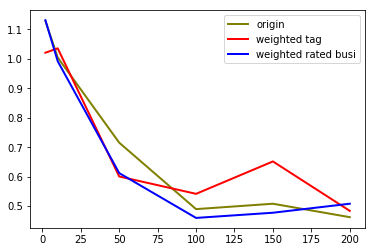

In [65]:
plt.plot('num_factors', 'mse', data=metric_0, marker='', color='olive', linewidth=2, label="origin")
plt.plot('num_factors', 'mse', data=metric_1, marker='', color='red', linewidth=2, label="weighted tag")
plt.plot('num_factors', 'mse', data=metric_3, marker='', color='blue', linewidth=2, label="weighted rated busi")
plt.legend()
plt.show()

## Model Exploration
Actually, the original one is the *basic Matric Factorization.* $$
(u, i) \rightarrow \mathbf{x}=(\underbrace{0, \ldots, 0,1,0, \ldots, 0}_{|U|}, \underbrace{0, \ldots, 0,1,0, \ldots, 0}_{|I|})
$$

With the side information, it can be interpreted as *SVD++.*
$$
\left(u, i,\left\{l_{1}, \ldots, l_{m}\right\}\right) \rightarrow \mathbf{x}=\underbrace{(0, \ldots, 1,0, \ldots, 0, \ldots, 1,0, \ldots, 0, \ldots, 1 / m, 0, \ldots, 1 / m, 0, \ldots)}_{|L|}
$$
And the FM model can be written as $$
\hat{y}(\mathbf{x})=\hat{y}\left(u, i,\left\{l_{1}, \ldots, l_{m}\right\}\right)=w_{0}+w_{u}+w_{i}+\left\langle\mathbf{v}_{u}, \mathbf{v}_{i}\right\rangle+\frac{1}{m} \sum_{j=1}^{m}\left\langle\mathbf{v}_{i}, \mathbf{v}_{l_{j}}\right\rangle
$$

## Some findings and thoughts
As the dimensionality of the factorized 2-way interactions goes up, MSE goes down. Also, the result goes steady after 100. Comparing the three inputs, origin, weighted tag and weighted rated business don't have so much difference. Considering the running time, I would rather use the original input: only user_id & business_id.

The model is not improved with side information. I have tried from both user side(business that user rated) and business side(business category). Why? 

But, we can see that the mode with side information really works a little better. In this case, maybe the origin data is enough for the predicting, and the side information cannot help much. The patterns of certain user can be learned by the business they rate. Also, the category can be recognized by the business itself. In some way, the side information is another repeating of the origin data. Furthermore, detailed side information may lead to some kind of overfitting, which offsets its positive effect.

Or, maybe it is because the data we use is too small? Let's try it in a larger data.

## Test on a larger dataset (user count = 50000)

We use the data of 50000 users, and show the results.

In [3]:
yelp = ratings.copy()

business_count = yelp["business_id"].value_counts()
active_business = business_count.loc[business_count >= 5]

k2 = active_business.quantile(0.8)
active_business = active_business.loc[active_business >= k2]
t2 = active_business.index.values
t2 = sample(t2.tolist(), 8500)

yelp = yelp[yelp['business_id'].isin(t2)]
print(len(yelp["user_id"].value_counts()))
print(len(yelp["business_id"].value_counts()))

617934
8500


In [4]:
user_count = yelp["user_id"].value_counts()
active_user = user_count.loc[user_count >= 5]
t1 = active_user.index.values
t1 = sample(t1.tolist(), 50000)

yelp = yelp[yelp['user_id'].isin(t1)]
print(len(yelp["user_id"].value_counts()))
print(len(yelp["business_id"].value_counts()))

50000
8497


In [7]:
sample1 = yelp.copy()
sample1['ind'] = sample1.index
sample1.date = pd.to_datetime(sample1.date)

test=sample1.sort_values(by=['user_id','date']).groupby("user_id")['date','ind'].max()

new_df=pd.DataFrame(test)
new_df = new_df.merge(sample1,on=['user_id','date'],how='left')

train=sample1[~sample1['ind'].isin(np.array(new_df['ind_x']))]

In [8]:
newf = train.copy()
newf['business_id'] = 'business'+newf['business_id']
#dict(list(newf.groupby('user_id')))
tempdata = newf[['user_id','business_id']]
newflist = list(map(lambda x:[x[0],list(map(lambda x:x[1],x[1].values.tolist()))],list(tempdata.groupby('user_id'))))

newf[['user_id','business_id']].groupby('user_id')

In [9]:
userdict = dict(newflist)
len(userdict)

50000

In [13]:
klist = [2,10,50,100,150,200]
N = 10

In [14]:
result0 = tune(0,klist,train,new_df,num_iter=N)

train size =  506825
data transfromed, time cost  19.77523398399353
origin MF num_factors= 2  FM MSE: 1.3417 time= 54.73871088027954
origin MF num_factors= 10  FM MSE: 1.3160 time= 81.74587392807007
origin MF num_factors= 50  FM MSE: 1.1190 time= 229.29810786247253
origin MF num_factors= 100  FM MSE: 1.0460 time= 407.6498398780823
origin MF num_factors= 150  FM MSE: 1.2513 time= 581.2007300853729
origin MF num_factors= 200  FM MSE: 1.0305 time= 802.6743910312653


In [15]:
result1 = tune(1,klist,train,new_df,num_iter=N)

train size =  506825
data transfromed, time cost  20.597522735595703
weighted tag num_factors= 2  FM MSE: 1.5763 time= 72.58612489700317
weighted tag num_factors= 10  FM MSE: 1.5067 time= 169.71379280090332
weighted tag num_factors= 50  FM MSE: 1.1148 time= 639.9866790771484
weighted tag num_factors= 100  FM MSE: 1.1640 time= 1222.2969689369202
weighted tag num_factors= 150  FM MSE: 1.1756 time= 1880.8377928733826
weighted tag num_factors= 200  FM MSE: 1.0380 time= 2544.3262617588043


In [16]:
result3 = tune(3,klist,train,new_df,num_iter=N)

train size =  506825
data transfromed, time cost  30.619023084640503
weighted rated num_factors= 2  FM MSE: 1.3156 time= 140.852783203125
weighted rated num_factors= 10  FM MSE: 1.5800 time= 503.0903322696686
weighted rated num_factors= 50  FM MSE: 1.0860 time= 2401.7710881233215
weighted rated num_factors= 100  FM MSE: 1.1240 time= 4654.943269968033
weighted rated num_factors= 150  FM MSE: 1.0540 time= 7525.392911911011
weighted rated num_factors= 200  FM MSE: 1.0896 time= 10297.6614382267


In [18]:
# build the metrix to store the result
metric_0 = pd.DataFrame({'mse':[x[2] for x in result0],'num_factors':[x[1] for x in result0]})
metric_1 = pd.DataFrame({'mse':[x[2] for x in result1],'num_factors':[x[1] for x in result1]})
metric_3 = pd.DataFrame({'mse':[x[2] for x in result3],'num_factors':[x[1] for x in result3]})

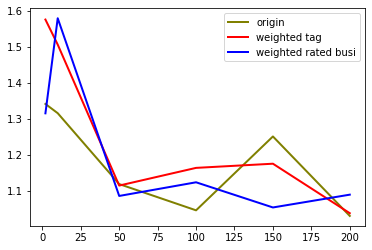

In [19]:
plt.plot('num_factors', 'mse', data=metric_0, marker='', color='olive', linewidth=2, label="origin")
plt.plot('num_factors', 'mse', data=metric_1, marker='', color='red', linewidth=2, label="weighted tag")
plt.plot('num_factors', 'mse', data=metric_3, marker='', color='blue', linewidth=2, label="weighted rated busi")
plt.legend()
plt.show()

## Compare with small dataset

Sadly, compared with small dataset, the MSE becomes larger. So, for this case, the model does not fit well. With more data, the model gets worse. We think the reason is that this model can not reflect the patterns of users. We should focus on the users. The large amount of data maybe dilutes the significance of user contribution to the model. 

## Why can not beat baseline?
Our baseline is user based model, and it emphasizes the user pattern. Actually I feel a little weird to make all the users, business and features into OneHotCode. As we mentioned before, it may dilute the significance of user contribution to the model and make it redundant. 

# Summary and Conclusion


In [3]:
#table of MSE values for all models
MSE_df

,model,MSE
0,Baseline,0.497
1,Time_aware,1.328
2,Content_based,2.043
3,Collective factorization,1.038


For this project, our objective is to predict user’s last rating based on user review history and business rating. To achieve our goal, we built Time-Aware, Content-based, Collective Factorization models along with our baseline model(user-based model) to do recommendations and predict ratings. Also, we utilized several metrics-- MSE, NDCG and Serendipity to evaluate each models and make comparisons of our result. Based all results we got above, it is clear that baseline model performs better overall comparing to other models since it has smaller MSE. Based on our objective, we think it is desirable to put base line model into our user last rating prediction since a better score recommendation can stimulate user’s interest to keep using Yelp app or attract new user to start using Yelp app. <br>
Limitations and future improvements are embedded in the summary part for each model. Further, Our team tried to build a deep learning model as taught in class. Unfortunately, due to the time limit and large dataset, we have only built part of the model and tested on small dataset, thus unable to include the model in the project. However, we will keep working on the deep learning model and make it a comprehensive project.